# Bayesian inference, Pyro, PyStan and VAEs

In this section, we give some examples on how to work with variational autoencoders and Bayesian inference using Pyro and PyStan.

This is meant to run using Nvidia CUDA processors. If you don't have a GPU installed in your computer, you can download this Jupyter notebook and upload it to [Google Colab](https://colab.research.google.com).

In [1]:
# Uncoment the line below to install pystan and pyro
!pip install "pystan<3"

  Using cached pystan-2.19.1.1-cp37-cp37m-manylinux1_x86_64.whl (67.3 MB)
  Attempting uninstall: pystan
    Found existing installation: pystan 3.1.1
    Uninstalling pystan-3.1.1:
      Successfully uninstalled pystan-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, which is not installed.
fbprophet 0.7.1 requires setuptools-git>=1.2, which is not installed.


In [1]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints

import pystan

from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import scipy.stats.kde as kde

import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

In [2]:
# Setup some data
theta = 0.6
n = 1000
y = stats.bernoulli.rvs(theta, size=n)

## Get MCMC samples for this model using Stan

In [3]:
#Compile model

model_code = """
data {
    int<lower=0> n;
    int y[n];
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    // likehood:
    y ~ bernoulli(theta);
    
    // prior:
    theta ~ beta(0.5, 0.5);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cbff015f4398d041dc3dc90aad40531c NOW.


In [4]:
# Sample model
data_dict = {'y': y, 'n': n}
fit = sm.sampling(data=data_dict, iter=1000, chains=4)

Some samples: [0.60787508 0.61294606 0.60779318 0.6198482  0.6322908  0.62482716
 0.609725   0.64162814 0.6130148  0.61417091]
Mean: 0.620723707592719
Standard deviation: 0.015404598636616335


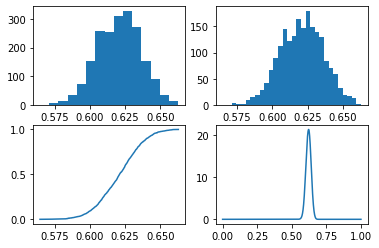

In [5]:
# Extract samples
theta = fit.extract(permuted=True)['theta']

# Print some statistics
print("Some samples:", theta[:10])
print("Mean:", np.mean(theta, axis=0))
print("Standard deviation:", np.std(theta, axis=0))

# Prepare plots
_, ax = plt.subplots(2, 2)

# histograms
# warning: for a caveat about using histogram see
# https://stats.stackexchange.com/a/51753
ax[0, 0].hist(theta, 15)
ax[0, 1].hist(theta, 30)

# Empirical cumulative distribution
ecdf = ECDF(theta)
ax[1, 0].plot(ecdf.x, ecdf.y)

# Density estimation using KDE (with tuning parameter chosen by 3 fold CV)
params_for_kde_cv = {'bandwidth': np.logspace(-2, 3, 10)}
grid = GridSearchCV(KernelDensity(), params_for_kde_cv, cv=3)
grid.fit(theta.reshape(-1, 1))
x_kde = np.linspace(0, 1, 10000).reshape(-1, 1)
y_kde = np.exp(grid.best_estimator_.score_samples(x_kde))
ax[1, 1].plot(x_kde, y_kde)

## Get MCMC samples for this model using Pyro

In [6]:
y_tensor = torch.as_tensor(y, dtype=torch.float32)

def model(y_tensor):
    prior_dist = dist.Beta(torch.Tensor([.5]), torch.Tensor([.5]))
    theta = pyro.sample('theta', prior_dist)
    with pyro.plate('observe_data'):
        pyro.sample('obs', dist.Bernoulli(theta), obs=y_tensor)

nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=300)
mcmc.run(y_tensor)

Sample: 100%|██████████| 800/800 [00:05, 138.99it/s, step size=1.10e+00, acc. prob=0.897]


In [7]:
posterior_simulations = mcmc.get_samples()['theta'].numpy().ravel()

In [8]:
print("Some samples:", posterior_simulations[:6])
print("Mean:", posterior_simulations.mean())
print("Standard deviation:", posterior_simulations.std())

Some samples: [0.6433877  0.6354131  0.62047493 0.5863722  0.6222383  0.6293913 ]
Mean: 0.6194563
Standard deviation: 0.015305086


## Get replications (new instances of similar to data) from MCMC samples

In [9]:
replications = stats.bernoulli.rvs(posterior_simulations)
print("P(Y=0|D) =", (replications == 0).mean())
print("P(Y=1|D) =", (replications == 1).mean())

P(Y=0|D) = 0.368
P(Y=1|D) = 0.632


## Get Bayesian credibility (HPD) intervals

In [10]:
# source: https://github.com/aloctavodia/BAP/blob/master/first_edition/code/Chp1/hpd.py
# licensed: https://github.com/aloctavodia/BAP/blob/master/LICENSE

def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
         x_hpd = x[(x > value[0]) & (x < value[1])]
         y_hpd = y[(x > value[0]) & (x < value[1])]
         modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

In [11]:
hpd_grid(posterior_simulations, 0.1)[0]

[(0.59, 0.65)]

## Get approximate Bayesian inference for Pyro and stochatisc variational inference

In [12]:
def model(y_tensor):
    prior_dist = dist.Beta(torch.Tensor([.5]), torch.Tensor([.5]))
    theta = pyro.sample('theta', prior_dist)
    with pyro.plate('observe_data'):
        pyro.sample('obs', dist.Bernoulli(theta), obs=y_tensor)

def guide(y_tensor):
    alpha = pyro.param("alpha", torch.Tensor([1.0]),
                       constraint=constraints.positive)
    beta = pyro.param("beta", torch.Tensor([1.0]),
                       constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Beta(alpha, beta))

In [73]:
# set up the optimizer
pyro.clear_param_store()
adam_params = {"lr": 0.2, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 100
# do gradient steps
for step in range(n_steps):
    svi.step(y_tensor)

Some samples: [0.77695346 0.57421271 0.69614649 0.45862063 0.55550441 0.72473446]
Mean: 0.6061601060480146
Standard deviation: 0.11371195167755946
--------------------------------------------------
P(Y=0|D) = 0.382
P(Y=1|D) = 0.618
--------------------------------------------------
90% HPD for theta:  [(0.42, 0.8)]


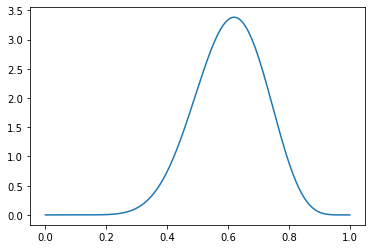

In [14]:
alpha = pyro.param("alpha").item()
beta = pyro.param("beta").item()
    
inf_distribution = stats.beta(alpha, beta)
print("Some samples:", inf_distribution.rvs(6))
print("Mean:", inf_distribution.mean())
print("Standard deviation:", inf_distribution.std())

# Plot the posterior
x_svi = np.linspace(0, 1, 10000)
y_svi = inf_distribution.pdf(x_svi)
plt.plot(x_svi, y_svi)

replications = stats.bernoulli.rvs(inf_distribution.rvs(1000))
print("-"*50)
print("P(Y=0|D) =", (replications == 0).mean())
print("P(Y=1|D) =", (replications == 1).mean())

print("-"*50)
print("90% HPD for theta: ", hpd_grid(inf_distribution.rvs(10000), 0.1)[0])

## Using GPU and data subsampling with Pyro 

In [84]:
# Setup some data for another model
mu = -0.6
sigma = 1.8

n2 = 10000
y2 = stats.norm.rvs(mu, sigma, size=n2)
y2_tensor = torch.as_tensor(y2, dtype=torch.float32).cuda()

RuntimeError: CUDA error: unspecified launch failure

In [16]:
def model(y2_tensor):
    # Priors:
    prior_dist_mu = dist.Normal(torch.Tensor([0.]).cuda(),
                                torch.Tensor([1.]).cuda())
    mu = pyro.sample('mu', prior_dist_mu)
    
    prior_dist_sigma = dist.Gamma(torch.Tensor([1.]).cuda(),
                                  torch.Tensor([1.]).cuda())
    sigma = pyro.sample('sigma', prior_dist_sigma)
    
    # Likelihood:
    with pyro.plate('observe_data', size=len(y2_tensor),
        subsample_size=5000, use_cuda=True) as ind:
        pyro.sample('obs', dist.Normal(mu, sigma),
            obs=y2_tensor.index_select(0, ind))
        

def guide(y2_tensor):
    alpha_mu = pyro.param("alpha_mu", torch.Tensor([0.0]).cuda())
    beta_mu = pyro.param("beta_mu", torch.Tensor([3.0]).cuda(),
        constraint=constraints.positive)
    mu = pyro.sample('mu', dist.Normal(alpha_mu, beta_mu))

    alpha_sigma = pyro.param("alpha_sigma", torch.Tensor([1.0]).cuda(),
        constraint=constraints.positive)
    beta_sigma = pyro.param("beta_sigma", torch.Tensor([1.0]).cuda(),
        constraint=constraints.positive)
    sigma = pyro.sample('sigma', dist.Gamma(alpha_sigma, beta_sigma))

In [17]:
# set up the optimizer
pyro.clear_param_store()
adam_params = {"lr": 0.2, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 10
# do gradient steps
for step in range(n_steps):
    svi.step(y2_tensor)

In [18]:
# Generate replications
no_replications = 10_000

alpha_mu = pyro.param("alpha_mu").item()
beta_mu = pyro.param("beta_mu").item()
alpha_sigma = pyro.param("alpha_sigma").item()
beta_sigma = pyro.param("beta_sigma").item()
    
mu_distribution = stats.norm(alpha_mu, beta)
sigma_distribution = stats.gamma(alpha_sigma, beta_sigma)

mu_samples = mu_distribution.rvs(no_replications)
sigma_samples = sigma_distribution.rvs(no_replications)

data_replications = stats.norm(mu_samples, sigma_samples).rvs()

In [24]:
# HDP interval for new data
print("P(X \in I | D) = 0.90, where\nI =", hpd_grid(data_replications, 0.1)[0])

P(X \in I | D) = 0.90, where
I = [(-14.02, 13.8)]


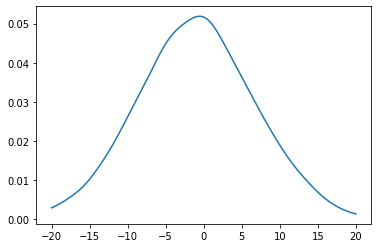

In [19]:
# Density estimation using KDE (with tuning parameter chosen by data splitting)
cv = ShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
params_for_kde_cv = {'bandwidth': np.logspace(-2, 3, 10)}
grid = GridSearchCV(KernelDensity(), params_for_kde_cv, cv=cv)
grid.fit(data_replications.reshape(-1, 1))
x_kde = np.linspace(-20, 20, 10000).reshape(-1, 1)
y_kde = np.exp(grid.best_estimator_.score_samples(x_kde))
plt.plot(x_kde, y_kde)

## Variational autoencoders

In [20]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, input_dim)
        self.fc22 = nn.Linear(hidden_dim, input_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        
        mu = self.fc21(hidden)
        sigma = torch.exp(self.fc22(hidden))
        return mu, sigma


# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, input_dim,
        z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim=input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim=input_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            mu, sigma = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Normal(mu, sigma).to_event(1), obs=x)
            # return the loc so we can visualize it later
            #return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
      
    def new_instances(self, size=1):
         z = stats.norm.rvs(size=(size, self.z_dim))
         mu, sigma = self.decoder.forward(torch.as_tensor(z,
             device=torch.device('cuda'), dtype=torch.float32))
         return stats.norm.rvs(mu.data.cpu().numpy(), sigma.data.cpu().numpy())

In [21]:
# clear param store
pyro.clear_param_store()

no_instances = 20000
input_dim = 3
mu = stats.norm.rvs(size=input_dim)

# Generate a positive definite matrix
sigma = stats.norm.rvs(size=(input_dim, input_dim))
sigma[np.triu_indices(input_dim)] = 0
sigma += np.diag(np.abs(stats.norm.rvs(size=input_dim)))
sigma = np.matmul(sigma.transpose(), sigma) # inverse cholesky decomposition

dataset = stats.multivariate_normal.rvs(mu, sigma, size=no_instances)
dataset = torch.as_tensor(dataset, dtype=torch.float32)
dataset = TensorDataset(dataset)
train_loader = DataLoader(dataset, batch_size=1000, shuffle=True,
     num_workers=1, pin_memory=True, drop_last=False)

# setup the VAE
vae = VAE(use_cuda=True, input_dim=input_dim)

adam_args = {"lr": 0.001}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
for epoch in range(100):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, in train_loader:
        x = x.cuda()
        epoch_loss += svi.step(x)

    # report training diagnostics
    if not epoch % 10:
        normalizer_train = len(train_loader.dataset)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo.append(total_epoch_loss_train)
        print("[epoch %03d]  average training loss: %.4f" %
             (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 20.3445
[epoch 010]  average training loss: 5.2740
[epoch 020]  average training loss: 5.1878
[epoch 030]  average training loss: 4.9342
[epoch 040]  average training loss: 4.7884
[epoch 050]  average training loss: 4.7438
[epoch 060]  average training loss: 4.7570
[epoch 070]  average training loss: 4.7772
[epoch 080]  average training loss: 4.7337
[epoch 090]  average training loss: 4.7261


In [22]:
# Generating new instances (replications) from the trained VAE
new_instances = vae.new_instances(100000)

print("True means")
print(mu)
print("Empirical means of replications:")
print(new_instances.mean(0))

print("----------------------------------------")

print("True covariance matrix")
print(sigma)
print("Empirical covariance matrix of replications:")
print(np.cov(new_instances, rowvar=False))

RuntimeError: CUDA error: unspecified launch failure